In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [3]:
df=pd.read_csv("/content/drive/MyDrive/DataSets/WIPRO.csv")
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,NaN,NaN,NaN
1,2000-01-04,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,NaN,NaN,NaN
2,2000-01-05,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,2000-01-06,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,NaN,NaN,NaN
4,2000-01-07,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
print(f'Dataframe contains stock prices between {df.Date.min()} and {df.Date.max()}')
print(f'Total days = {(df.Date.max() - df.Date.min()).days} days')

Dataframe contains stock prices between 2000-01-03 00:00:00 and 2021-04-30 00:00:00
Total days = 7788 days


In [6]:
print("number of NaN values for the column Close :", df['Close'].isnull().sum())
print("number of NaN values for the column Volume :", df['Volume'].isnull().sum())
print("number of NaN values for the column Trades :", df['Trades'].isnull().sum())
print("number of NaN values for the column Deliverable Volume :", df['Deliverable Volume'].isnull().sum())
print("number of NaN values for the column %Deliverble :", df['%Deliverble'].isnull().sum())

number of NaN values for the column Close : 0
number of NaN values for the column Volume : 0
number of NaN values for the column Trades : 2850
number of NaN values for the column Deliverable Volume : 509
number of NaN values for the column %Deliverble : 509


In [7]:
# If Trades, Deliverable Volume and %Deliverable are required, perform EDA
mean = df['Trades'].mean()
df['Trades'].replace(np.nan,mean, inplace=True)
mean = df['Deliverable Volume'].mean()
df['Deliverable Volume'].replace(np.nan,mean, inplace=True)
mean = df['%Deliverble'].mean()
df['%Deliverble'].replace(np.nan,mean, inplace=True)

<Axes: >

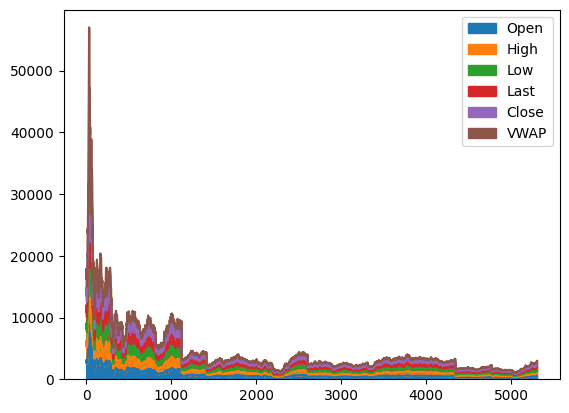

In [8]:
df[['Open','High','Low','Last','Close','VWAP']].plot(kind='area')

In [9]:
layout = go.Layout(
    title='Stock Prices of Wipro',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

wipro_data = [{'x':df['Date'], 'y':df['Close']}]
plot = go.Figure(data=wipro_data, layout=layout)

In [10]:
iplot(plot)

In [11]:
train_set=df.iloc[:,8:9].values
train_set

array([[2724.2 ],
       [2942.15],
       [2990.1 ],
       ...,
       [ 489.3 ],
       [ 489.85],
       [ 492.75]])

Feature Scaling using MinMax Scaler

In [12]:
sc=MinMaxScaler()
train_set=sc.fit_transform(train_set)

In [13]:
len(train_set)

5306

In [14]:
x_train=train_set[0:5000]
y_train=train_set[1:5001]

In [15]:
x_train.shape

(5000, 1)

In [16]:
x_train=np.reshape(x_train,(5000,1,1))
x_train

array([[[0.27181144]],

       [[0.29493586]],

       [[0.30002334]],

       ...,

       [[0.00789912]],

       [[0.00796278]],

       [[0.00826516]]])

Building the RNN Model

In [17]:
model=Sequential(
    [
        LSTM(units=50, return_sequences=True,
             input_shape=(None,1)),
        LSTM(units=50, return_sequences=True),
        Dropout(0.25),
        Dense(1,activation='sigmoid')
    ]
    )

Compiling the RNN Model

In [18]:
model.compile(optimizer='adam',loss='mean_squared_error')

Training the RNN Model

In [19]:
model.fit(x_train,y_train,batch_size=10,epochs=100)

Epoch 1/100
500/500 [==============================] - 6s 4ms/step - loss: 0.0310
Epoch 2/100
500/500 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 3/100
500/500 [==============================] - 2s 3ms/step - loss: 5.3803e-04
Epoch 4/100
500/500 [==============================] - 1s 3ms/step - loss: 4.9150e-04
Epoch 5/100
500/500 [==============================] - 1s 3ms/step - loss: 4.5479e-04
Epoch 6/100
500/500 [==============================] - 1s 3ms/step - loss: 4.6127e-04
Epoch 7/100
500/500 [==============================] - 1s 3ms/step - loss: 4.3892e-04
Epoch 8/100
500/500 [==============================] - 1s 3ms/step - loss: 4.2706e-04
Epoch 9/100
500/500 [==============================] - 1s 3ms/step - loss: 4.2669e-04
Epoch 10/100
500/500 [==============================] - 2s 4ms/step - loss: 4.0924e-04
Epoch 11/100
500/500 [==============================] - 2s 4ms/step - loss: 4.3232e-04
Epoch 12/100
500/500 [==============================] - 1s 3

In [20]:
test_set=pd.read_csv("/content/drive/MyDrive/DataSets/WIPRO.csv")
test_set.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,NaN,NaN,NaN
1,2000-01-04,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,NaN,NaN,NaN
2,2000-01-05,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,2000-01-06,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,NaN,NaN,NaN
4,2000-01-07,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


In [21]:
test_set=df.iloc[5000:5305,8:9].values
inputs = sc.fit_transform(test_set)
inputs

array([[0.24396947],
       [0.24824427],
       [0.24916031],
       [0.23984733],
       [0.24091603],
       [0.25068702],
       [0.24854962],
       [0.2459542 ],
       [0.24870229],
       [0.24946565],
       [0.26030534],
       [0.25450382],
       [0.24992366],
       [0.24961832],
       [0.23679389],
       [0.21145038],
       [0.18045802],
       [0.17847328],
       [0.18732824],
       [0.20305344],
       [0.20564885],
       [0.18687023],
       [0.1589313 ],
       [0.15496183],
       [0.11221374],
       [0.1070229 ],
       [0.05312977],
       [0.03282443],
       [0.02320611],
       [0.        ],
       [0.05145038],
       [0.02381679],
       [0.04274809],
       [0.03755725],
       [0.06183206],
       [0.06458015],
       [0.06656489],
       [0.1048855 ],
       [0.08290076],
       [0.05389313],
       [0.09022901],
       [0.09328244],
       [0.1048855 ],
       [0.08198473],
       [0.07389313],
       [0.0778626 ],
       [0.07526718],
       [0.057

In [22]:
len(inputs)

305

In [23]:
inputs.shape

(305, 1)

In [24]:
inputs=np.reshape(inputs,(305,1,1))
inputs

array([[[0.24396947]],

       [[0.24824427]],

       [[0.24916031]],

       [[0.23984733]],

       [[0.24091603]],

       [[0.25068702]],

       [[0.24854962]],

       [[0.2459542 ]],

       [[0.24870229]],

       [[0.24946565]],

       [[0.26030534]],

       [[0.25450382]],

       [[0.24992366]],

       [[0.24961832]],

       [[0.23679389]],

       [[0.21145038]],

       [[0.18045802]],

       [[0.17847328]],

       [[0.18732824]],

       [[0.20305344]],

       [[0.20564885]],

       [[0.18687023]],

       [[0.1589313 ]],

       [[0.15496183]],

       [[0.11221374]],

       [[0.1070229 ]],

       [[0.05312977]],

       [[0.03282443]],

       [[0.02320611]],

       [[0.        ]],

       [[0.05145038]],

       [[0.02381679]],

       [[0.04274809]],

       [[0.03755725]],

       [[0.06183206]],

       [[0.06458015]],

       [[0.06656489]],

       [[0.1048855 ]],

       [[0.08290076]],

       [[0.05389313]],

       [[0.09022901]],

       [[0.09328

Scaling the Test Data

In [25]:
predicted_values=model.predict(inputs)
predicted_values

10/10 [==============================] - 1s 3ms/step


array([[[0.23296034]],

       [[0.2365878 ]],

       [[0.23736514]],

       [[0.22946128]],

       [[0.23036866]],

       [[0.23866086]],

       [[0.23684691]],

       [[0.23464458]],

       [[0.23697646]],

       [[0.23762427]],

       [[0.24683258]],

       [[0.24190132]],

       [[0.23801297]],

       [[0.23775384]],

       [[0.22686757]],

       [[0.20517409]],

       [[0.17774704]],

       [[0.17593856]],

       [[0.18395191]],

       [[0.19787185]],

       [[0.20013729]],

       [[0.1835408 ]],

       [[0.15770128]],

       [[0.15389302]],

       [[0.11052032]],

       [[0.1049969 ]],

       [[0.04849781]],

       [[0.03066696]],

       [[0.02358662]],

       [[0.01082131]],

       [[0.04689919]],

       [[0.02400632]],

       [[0.03894608]],

       [[0.03450063]],

       [[0.05705721]],

       [[0.05984294]],

       [[0.06187562]],

       [[0.10271198]],

       [[0.07907965]],

       [[0.04923064]],

       [[0.08695243]],

       [[0.09024

In [26]:
predicted_values.shape

(305, 1, 1)

In [27]:
predicted_values=np.reshape(predicted_values,(305,1))
predicted_values

array([[0.23296034],
       [0.2365878 ],
       [0.23736514],
       [0.22946128],
       [0.23036866],
       [0.23866086],
       [0.23684691],
       [0.23464458],
       [0.23697646],
       [0.23762427],
       [0.24683258],
       [0.24190132],
       [0.23801297],
       [0.23775384],
       [0.22686757],
       [0.20517409],
       [0.17774704],
       [0.17593856],
       [0.18395191],
       [0.19787185],
       [0.20013729],
       [0.1835408 ],
       [0.15770128],
       [0.15389302],
       [0.11052032],
       [0.1049969 ],
       [0.04849781],
       [0.03066696],
       [0.02358662],
       [0.01082131],
       [0.04689919],
       [0.02400632],
       [0.03894608],
       [0.03450063],
       [0.05705721],
       [0.05984294],
       [0.06187562],
       [0.10271198],
       [0.07907965],
       [0.04923064],
       [0.08695243],
       [0.09024111],
       [0.10271198],
       [0.07809941],
       [0.06950636],
       [0.07370493],
       [0.07095539],
       [0.052

Reverse Scaling to get back the Original Data

In [28]:
test_pred=sc.inverse_transform(predicted_values)
test_pred

array([[238.64452],
       [239.8325 ],
       [240.08708],
       [237.49857],
       [237.79573],
       [240.51143],
       [239.91736],
       [239.19609],
       [239.9598 ],
       [240.17194],
       [243.18767],
       [241.57268],
       [240.29926],
       [240.21439],
       [236.64914],
       [229.54453],
       [220.56215],
       [219.96988],
       [222.59425],
       [227.15303],
       [227.89496],
       [222.45961],
       [213.99716],
       [212.74997],
       [198.54541],
       [196.73648],
       [178.23303],
       [172.39343],
       [170.07462],
       [165.89398],
       [177.70947],
       [170.21207],
       [175.10483],
       [173.64896],
       [181.03624],
       [181.94858],
       [182.61426],
       [195.98817],
       [188.24858],
       [178.47304],
       [190.82692],
       [191.90396],
       [195.98817],
       [187.92755],
       [185.11334],
       [186.48836],
       [185.58788],
       [179.54315],
       [176.63567],
       [177.09895],


In [50]:
print("The Error Rate of Prediction Model:",mean_absolute_percentage_error(test_pred,test_set))
print("The Accuracy of Prediction Model:",(1-mean_absolute_percentage_error(test_pred,test_set)))

The Error Rate of Prediction Model: 0.014395070990139635
The Accuracy of Prediction Model: 0.9856049290098604


Visualizing the Data

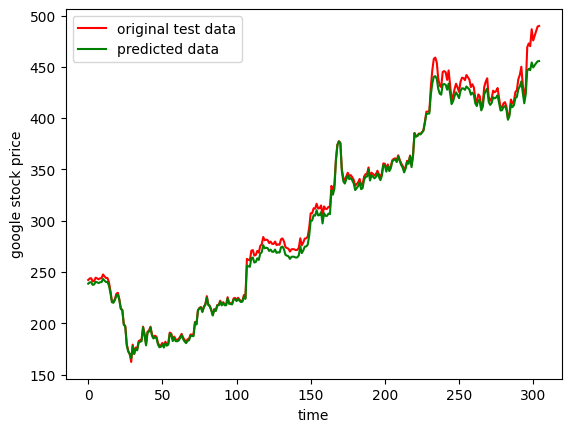

In [51]:
plt.plot(test_set,color='red',label='original test data')
plt.plot(test_pred,color='green',label='predicted data')
plt.xlabel('time')
plt.ylabel('google stock price')
plt.legend()
plt.show()

In [52]:
today_price=float(input("Enter Today's Stock Price: "))

Enter Today's Stock Price: 521.27


Converting into 2D array and Scaling the Data

In [53]:
arr=np.array(today_price).reshape(-1,1)
arr1=sc.transform(arr)
arr1=arr1.reshape(-1,1,1)

In [54]:
result=model.predict(arr1)
print(result)
result=np.reshape(result,(1,1))

1/1 [==============================] - 0s 20ms/step
[[[0.9282093]]]


Converting back the Scaled Data to Original data

In [55]:
tomorrow_price=sc.inverse_transform(result)
print("Predicted price tomorrow=%.2f" % tomorrow_price, end='')

Predicted price tomorrow=466.34